# IMPORTS

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import lightgbm as lgb
import xgboost

from datetime import datetime, date
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

# PLOTTING PARAMETERS

In [2]:
tex_fonts = {
        "text.usetex": True,
        "font.family": "serif",
        "axes.titlesize": 10, 
        "axes.labelsize": 10,
        "font.size": 10,
        "legend.fontsize": 'xx-small',
        "legend.title_fontsize": 10,
        "xtick.labelsize": 8, #'xx-small',
        "ytick.labelsize": 8, #'xx-small',
        "ps.usedistiller": "xpdf"
        }
plt.rcParams.update(tex_fonts)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb,underscore}'

cm=1/2.54

# PATHS

In [3]:
path_data = Path('./input')

In [4]:
path_plots = Path('./plots')

# FUNCTIONS

In [5]:
def plot_ts_split(ts_cv, X, y, path, filename, cm):
    
    fig, ax = plt.subplots(figsize=(10*cm, 5*cm))
    
    for i, (train, test) in enumerate(ts_cv.split(X, y)):
        ax_train = ax.scatter(train, [i] * len(train), c='black', marker="_", lw=8)
        ax_test  = ax.scatter(test, [i] * len(test), c='red', marker="_", lw=8)
    
    ax.set(
        title="Time-series split",
        xlabel="Data Index",
        ylabel="Cross-validation iteration",
        ylim=[5, -1],
    )
    ax.legend([ax_train, ax_test], ["Training", "Testing"])
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

In [6]:
def ts_cv_score(X , y, n_split, n_est, plot_ts, path, cm):
    
    # plot_ts is True/False, decides wheteher the splitting of time series has to be shown  
    
    from sklearn.model_selection import TimeSeriesSplit, cross_validate
    from sklearn.ensemble import RandomForestRegressor
    
    # Initialize time series split
    ts_cv = TimeSeriesSplit(n_splits=n_split) 
    
    if plot_ts:
        plot_ts_split(ts_cv, X, y, path_plots, 'time-series_splitting_'+ str(n_split) + '_iterations.pdf', cm)    
    
    # Initialize random forest regressor
    rf = RandomForestRegressor(n_estimators=n_est, random_state=1121218)

    scores = cross_validate(rf, X, y, cv=ts_cv, scoring="neg_mean_squared_log_error", return_estimator=True)

    # Base RMSLE
    base_rmsle = np.sqrt(-np.mean(scores["test_score"]))
    
    print("Base Root Meat Squared Log Error is: {:.5f}".format(base_rmsle))

# IMPORT DATA

## TRAINING data

### Import (Kaggle) clean data

In [7]:
# IMPORT CLEAN DATA FROM THE data_cleaning notebook

input_filename = path_data / 'clean_data.gz'
data = pd.read_csv(input_filename, 
                   compression=dict(method='gzip'),
                   index_col='index',
                   dtype={#'store_nbr': 'category',
                          'dayname': 'category',
                         },
                   parse_dates=['date'],
                   infer_datetime_format=True,
                  ) 
data['date'] = pd.to_datetime(data['date'])
'''
csv I/O removes any categorical information (categories and ordering). 
Such info has to be re initialized, or stored in a hdf files
'''
listdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
liststore = list(range(1, 55))
# pd.Categorical() to set the order according to the 'days' list
data.dayname = pd.Categorical(data.dayname, categories=listdays, ordered=True)
data.store_nbr = pd.Categorical(data.store_nbr, categories=liststore, ordered=True)
data['dayofmonth'] = data.date.dt.day

data.head()

/tmp/ipykernel_5347/2502291277.py:4: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(input_filename,


,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,locale,...,dayname,dayofyear,week,year,Terremoto,Futbol,CyberMonday,BlackFriday,Madre,dayofmonth
index,,,,,,,,,,,,,,,,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,National,...,Tuesday,1,1,2013,False,False,False,False,False,1
1,2016-01-01,21,POULTRY,0.0,0,Santo Domingo,Santo Domingo de los Tsachilas,B,6,National,...,Friday,1,53,2016,False,False,False,False,False,1
2,2016-01-01,21,PREPARED FOODS,0.0,0,Santo Domingo,Santo Domingo de los Tsachilas,B,6,National,...,Friday,1,53,2016,False,False,False,False,False,1
3,2016-01-01,21,PRODUCE,0.0,0,Santo Domingo,Santo Domingo de los Tsachilas,B,6,National,...,Friday,1,53,2016,False,False,False,False,False,1
4,2016-01-01,21,SCHOOL AND OFFICE SUPPLIES,0.0,0,Santo Domingo,Santo Domingo de los Tsachilas,B,6,National,...,Friday,1,53,2016,False,False,False,False,False,1


## Kaggle TESTING data

Note that this data is meant for a kaggle competition.

It cannot be used for testing purpose of our algorithms since the outcome of the competion is not known.

We will prepare later some testing data for our own purposes.

### Import stores data

In [8]:
stores = pd.read_csv(
    path_data / 'stores.csv',
    dtype={'store_nbr': 'category',
           'city': 'category',
           'state': 'category',
           'type': 'category',
           'cluster': 'category'
           },
    )
# type already use as column name
stores.rename(columns={'type': 'store_type'}, inplace=True)
stores.head()

,store_nbr,city,state,store_type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Prepare Kaggle testing data

In [9]:
test_in = pd.read_csv(
    path_data / 'test.csv',
    usecols=['store_nbr', 'family', 'date', 'onpromotion'],
    dtype={'store_nbr': 'category',
           'family': 'category',
           'onpromotion': 'uint32',
          },
    parse_dates=['date'],
    infer_datetime_format=True,
    )

pd.to_datetime(test_in['date'])
test_in.head()

,date,store_nbr,family,onpromotion
0,2017-08-16,1,AUTOMOTIVE,0
1,2017-08-16,1,BABY CARE,0
2,2017-08-16,1,BEAUTY,2
3,2017-08-16,1,BEVERAGES,20
4,2017-08-16,1,BOOKS,0


In [10]:
# Merge test and stores
test2 = test_in.merge(stores, on='store_nbr', how='left')
test2.head()

,date,store_nbr,family,onpromotion,city,state,store_type,cluster
0,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13
1,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13
2,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13
3,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13
4,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13


In [11]:
# Import holidays in the test data
hol_test = pd.read_csv(path_data / 'hol_test.csv',
                       usecols = ['date', 'locale', 'locale_name', 'status', 'Terremoto', 'Futbol', 'CyberMonday', 'BlackFriday', 'Madre'],
                       dtype={#'store_nbr': 'category',
                              'dayname': 'category',
                              },
                       parse_dates=['date'],
                       infer_datetime_format=True,
                      ) 
hol_test['date'] = pd.to_datetime(hol_test['date'])
hol_test

,date,locale,locale_name,status,Terremoto,Futbol,CyberMonday,BlackFriday,Madre
0,2017-08-24,Local,Ambato,holiday,False,False,False,False,False


In [12]:
# Merge the outcome with holidays
test3 = test2.merge(hol_test, on='date', how='left')

# At this stage we have a lot of NaNs comimg from hol_test
# except the single day with holiday information in the test sample
# this is a local holiday at the city 'Ambato'

# fill in status with 'holiday' only when 'city' == 'locale_name' (i. e., Ambato)
# data in hol_test is simple, so next line is not necessary
# test3.loc[~test3.status.isna() and (test3.city==test3.locale_name), 'status'] = 'holiday'

# else fill in with 'work'
test3.loc[test3.city!=test3.locale_name, 'status'] = 'work'

# fill in NaNs
test3.loc[test3.Terremoto.isna(), 'Terremoto'] = False
test3.loc[test3.Futbol.isna(), 'Futbol'] = False
test3.loc[test3.CyberMonday.isna(), 'CyberMonday'] = False
test3.loc[test3.BlackFriday.isna(), 'BlackFriday'] = False
test3.loc[test3.Madre.isna(), 'Madre'] = False

# add boolean column 'workday'
test3['Workday'] = np.where(test3['status']=='Work', False, True)

# add boolean column 'promotion'
test3['Promotion'] = np.where(test3['onpromotion']>0, False, True)

# drop columns (locale, locale name)
test3.drop(columns=['locale', 'locale_name'], inplace=True)
# sanity check
test3.loc[test3.status=='holiday'].city.unique()

['Ambato']
Categories (22, object): ['Ambato', 'Babahoyo', 'Cayambe', 'Cuenca', ..., 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']

In [13]:
test3.head()

,date,store_nbr,family,onpromotion,city,state,store_type,cluster,status,Terremoto,Futbol,CyberMonday,BlackFriday,Madre,Workday,Promotion
0,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,work,False,False,False,False,False,True,True
1,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,work,False,False,False,False,False,True,True
2,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,work,False,False,False,False,False,True,False
3,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,work,False,False,False,False,False,True,False
4,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,work,False,False,False,False,False,True,True


In [14]:
test_sales = (
    test3
    .groupby('date').mean()
    .squeeze()
)
test_sales.head()

,onpromotion,Workday,Promotion
date,,,
2017-08-16,17.137486,1.0,0.436027
2017-08-17,4.211560,1.0,0.609989
2017-08-18,7.731201,1.0,0.514029
2017-08-19,4.833895,1.0,0.557239
2017-08-20,5.338384,1.0,0.581369


# TESTING FORECASTING USING AVERAGE SALES

In [15]:
## Prepare (own) TRAINING data

### Split input data

In [16]:
# Location information
list_locale = ['date', 'store_nbr', 'family', 'city', 'state', 'store_type', 'cluster', 'locale', 'locale_name', 'status']
locale_in = data.loc[:,list_locale]

In [17]:
# indicators
list_indic = ['date', 'onpromotion', 'status', 'Terremoto', 'Futbol', 'CyberMonday', 'BlackFriday', 'Madre']
indic_in = data.loc[:,list_indic]

In [18]:
# Average sales (includes date information as it will not be modified by groupby+mean)
list_sales = ['date', 'sales', 'onpromotion', 'day', 'dayofyear', 'week', 'year', 'dayofmonth']
average_sales = data.loc[:,list_sales]

In [19]:
average_sales = (
    average_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)
average_sales.head()

,sales,onpromotion,day,dayofyear,week,year,dayofmonth
date,,,,,,,
2017-01-01,6.780304,0.095398,6.0,1.0,52.0,2017.0,1.0
2017-01-02,786.928379,6.628507,0.0,2.0,1.0,2017.0,2.0
2017-01-03,619.740224,7.803591,1.0,3.0,1.0,2017.0,3.0
2017-01-04,555.608004,12.860831,2.0,4.0,1.0,2017.0,4.0
2017-01-05,436.375395,4.797980,3.0,5.0,1.0,2017.0,5.0


In [20]:
y = average_sales.sales
y.head()

date
2017-01-01      6.780304
2017-01-02    786.928379
2017-01-03    619.740224
2017-01-04    555.608004
2017-01-05    436.375395
Name: sales, dtype: float64

### Create simple features for dates in averages_sales

In [21]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [22]:
# Create features for dates in averages_sales

fourier = CalendarFourier(freq='M', order=4)

dp = DeterministicProcess(
    index=y.index,                # dates from the training data
    constant=True,               # dummy feature for the bias (y_intercept)
    order=1,                      # the time dummy (trend)
    seasonal=True,                # weekly seasonality (dealt with via indicators) 
    additional_terms = [fourier], # monthly seasonality (dealt with via Fourier coefficients)
    drop=True,                    # drop terms if necessary to avoid collinearity
)

X = dp.in_sample()

In [23]:
print(X.head())

            const  trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                       
2017-01-01    1.0    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-02    1.0    2.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-01-03    1.0    3.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-01-04    1.0    4.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-01-05    1.0    5.0     0.0     0.0     0.0     1.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
date                                                                     
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-02       0.201299       0.979530       0.394356       0.918958   
2017-01-03       0.394356       0.918958       0.724793       0.688967   
2017-01-04       0.571268       0.820763       0.937752       0.347305   
2017-01-05       0.7247

#### We have 1 trend term (const), 7 weekly indicators, and 8 Fourier terms

### Simple fit of averages_sales

In [24]:
model = LinearRegression().fit(X,y)
y_pred = pd.Series(model.predict(X), index=X.index)

In [25]:
def plot_ts_fit(train, fit, xlab, ylab, title, path, filename, cm):
    
    fig = plt.figure(figsize=(18*cm, 12*cm))
    ax = fig.add_subplot(111)
    
    #ax1 = ax.plot(average_sales.dayofyear,average_sales.sales, c='blue', label = 'Training data')
    #ax2 = ax.plot(average_sales.dayofyear,y_pred, c='red')
    ax1 = ax.plot(train.dayofyear,train.sales, c='blue', label = 'Training data')
    ax2 = ax.plot(train.dayofyear,fit, c='red', label = 'Fit to the training data')
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    
    ax.legend(title=None,
              loc="upper right",
              )
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')

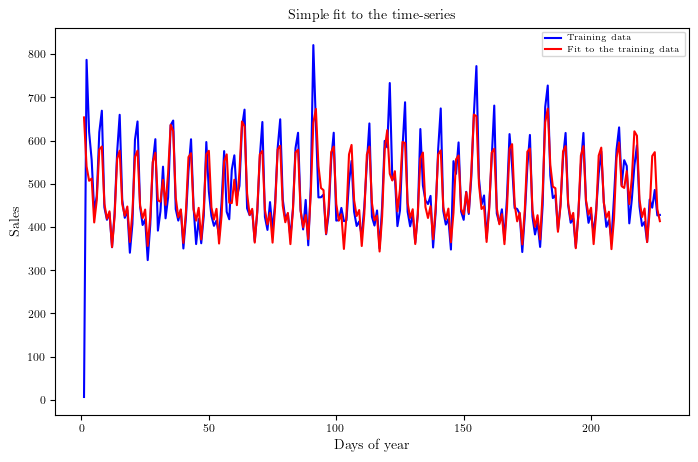

In [26]:
plot_ts_fit(average_sales, y_pred, 'Days of year', 'Sales', 'Simple fit to the time-series', path_plots, 'forecasting_simple_fit.pdf', cm)

The fit is not too bad, but far from being perfect. Such a behaviour is not surprising since the analysis is made on average sales without taking into account the extra information on individual stores and product categories

Base Root Meat Squared Log Error is: 0.14447


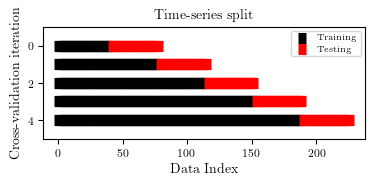

In [27]:
ts_cv_score(X , y, 5, 1000, True, path_plots, cm)

### Add single feature for holidays

The input dataframe is optimized for dealing with individual shops and product families. Here we are dealing with average sales, so we restart from scratch (holidays_events) to prepare the holiday-related feature

In [28]:
holidays_events = pd.read_csv(
    path_data / "holidays_events.csv",
    dtype={'type': 'category',
          'locale': 'category',
          'locale_name': 'category',
          'description': 'category',
          'transferred': 'bool',#
          },
    parse_dates=['date'],
    infer_datetime_format=True,
    )

pd.to_datetime(holidays_events['date'])
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [29]:
mask_date = (holidays_events.date > '2017-01-11') & (holidays_events.date <= '2017-08-15')

We work under the hypothesis that local holidays have low impact on state-wide average sales, so we focus only on national and regional holidays

In [30]:
temp = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc[mask_date, ['date', 'locale']]
)
temp['holiday'] = 1.0
holidays = temp.drop(columns=['locale']).set_index('date', drop=True)

In [31]:
# average_sales does not contain NaNs, then we can use fillna to fill in the 'work' column for norma working days
X_hol = average_sales.merge(holidays, on='date', how='left').fillna(0.0)['holiday']
X_hol.head()

date
2017-01-01    0.0
2017-01-02    0.0
2017-01-03    0.0
2017-01-04    0.0
2017-01-05    0.0
Name: holiday, dtype: float64

In [32]:
X2 = X.join(X_hol, on='date')
X2.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",holiday
date,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,0.0


In [33]:
model2 = LinearRegression().fit(X2,y)
y_pred2 = pd.Series(model2.predict(X2), index=X2.index)

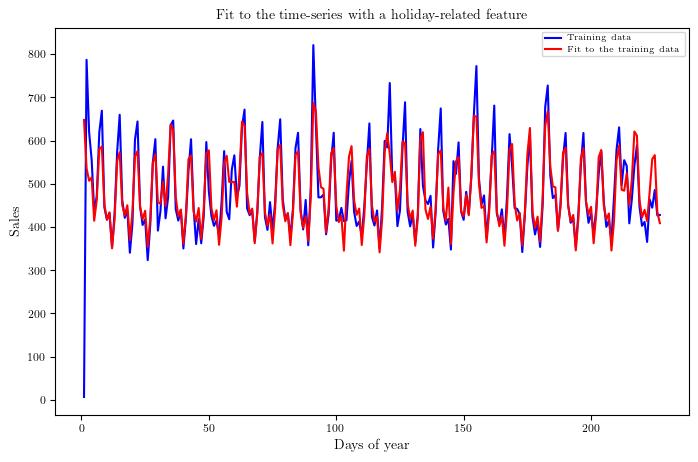

In [34]:
plot_ts_fit(average_sales, y_pred2, 'Days of year', 'Sales', 'Fit to the time-series with a holiday-related feature', path_plots, 'forecasting_holiday_feature_fit.pdf', cm)

From a simple visual inspection of the time series, there seems to be very little (if any) improvement when compared with the version without holidays

The comparison between the two prediction reveals however that the predictions are modified, and this, exactly et the specified holidays

Text(0.5, 1.0, 'Difference between predictions')

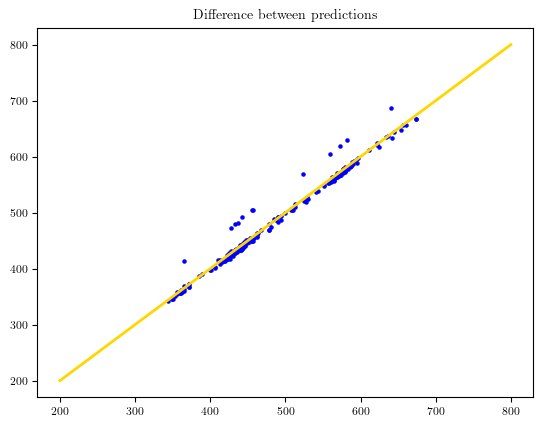

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_pred,y_pred2, s=5, c='blue')
ax.plot([200,800],[200,800], lw=2, c='gold')
ax.set_title(r'Difference between predictions')

In [36]:
ts_cv_score(X2 , y, 5, 1000, False, path_plots, cm)

Base Root Meat Squared Log Error is: 0.14343


Indeed, the gain in score is marginal, going down from 0.14447 to 0.14343

### ALTERNATIVE: Add a specific feature for each single holiday

In [37]:
holtest = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc[mask_date, ['date','description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
).set_index('date', drop=True)
holtest.head()

,description
date,
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo


In [38]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

X_holtest = pd.DataFrame(
    ohe.fit_transform(holtest),
    index = holtest.index,
    columns = holtest.description.unique(),
)

In [39]:
X3 = X.join(X_holtest, on='date').fillna(0.0)

In [40]:
X3.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,Provincializacion de Cotopaxi,Viernes Santo,Dia del Trabajo,Dia de la Madre-1,Dia de la Madre,Batalla de Pichincha,Traslado Batalla de Pichincha,Provincializacion de Imbabura,Primer Grito de Independencia,Traslado Primer Grito de Independencia
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
model3 = LinearRegression().fit(X3,y)
y_pred3 = pd.Series(
    model3.predict(X3),
    index = X3.index,
)

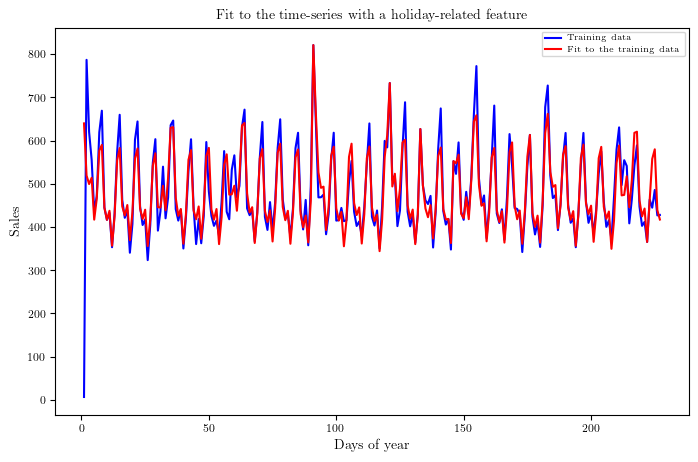

In [42]:
plot_ts_fit(average_sales, y_pred3, 'Days of year', 'Sales', 'Fit to the time-series with a holiday-related feature', path_plots, 'forecasting_holiday_feature_fit.pdf', cm)

The visual inspection of the time series shows an improvement of the fit, and this is confirmed by the comparison of the predictions

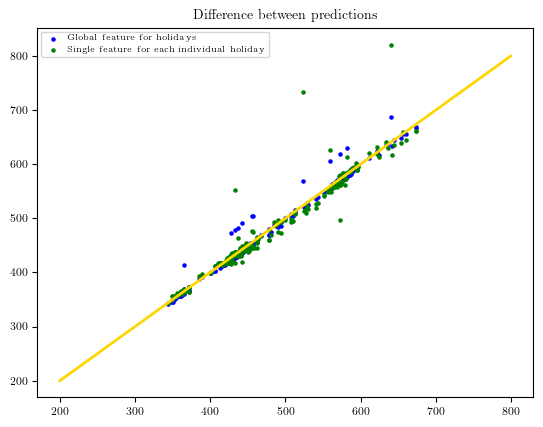

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_pred,y_pred2, s=5, label='Global feature for holidays', c='blue')
ax.scatter(y_pred,y_pred3, s=5, label='Single feature for each individual holiday', c='green')
ax.plot([200,800],[200,800], lw=2, c='gold')
ax.set_title(r'Difference between predictions')
ax.legend(loc='upper left')

In [44]:
ts_cv_score(X3 , y, 5, 1000, False, path_plots, cm)

Base Root Meat Squared Log Error is: 0.14386


Although the fit looks better, the score is less good (0.14386 instead of 0.14343), still better than the original value of 0.14447.

### Add Lag feature(s)

#### Partial autocorrelation

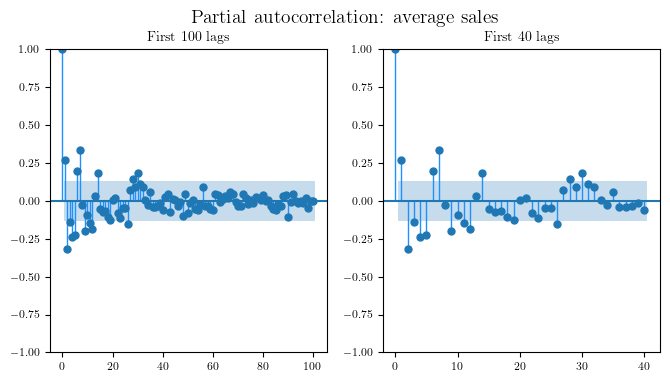

In [45]:
fig, ax = plt.subplots(1,2, figsize=(20*cm, 10*cm))
fig.suptitle("Partial autocorrelation: average sales", fontsize=14)
p1 = sm.graphics.tsa.plot_pacf(average_sales.sales, lags=100, method='ywm', ax=ax[0], \
                                      title = 'First 100 lags', \
                                      vlines_kwargs={'color': 'dodgerblue', 'lw':1})

p2 = sm.graphics.tsa.plot_pacf(average_sales.sales, lags=40, method='ywm', ax=ax[1], \
                                      title = 'First 40 lags', \
                                      vlines_kwargs={'color': 'dodgerblue', 'lw':1})

In [46]:
def get_lags_sorted_by_pacf(ts, nlags, alpha, threshold):
    
    import statsmodels.api as sm

    # return pacf, confidence intervals for the first nlags lags
    pacf1, ci = sm.tsa.pacf(average_sales.sales, nlags=40, alpha=0.05)
    # transform into df
    pacf = pd.DataFrame(pacf1,columns=['value'])
    # get absolute value
    pacf['value'] = pacf['value'].abs()
    # get index as lag identifier
    pacf['lag'] = pacf.index
    # sort by value and keep only the lags above thereshold
    pacf.sort_values(by='value', ascending=False, inplace =True, ignore_index=True)
    
    return pacf.loc[(pacf.value<1.0) & (pacf.value>threshold)]

In [47]:
pacf = get_lags_sorted_by_pacf(average_sales.sales, nlags=40, alpha=0.05, threshold=0.2)
pacf

,value,lag
1,0.353575,7
2,0.321636,2
3,0.272781,1
4,0.242270,4
5,0.235145,30
6,0.233917,5
7,0.214435,14
8,0.212701,9
9,0.207263,28
10,0.202131,12


In [48]:
lag_list = pacf.lag.to_list()
lag_list

[7, 2, 1, 4, 30, 5, 14, 9, 28, 12, 6]

In [49]:
Xlag_init = average_sales.copy()

In [50]:
def create_lag_features(df, column, lag_list):
    
    for lag in lag_list:
        df['lag_' + str(lag)] = df[column].shift(lag).fillna(0.0)
        
    return df 

In [51]:
create_lag_features(Xlag_init, 'sales', lag_list)
Xlag = Xlag_init.drop(columns=['sales', 'onpromotion', 'day', 'week', 'year', 'dayofmonth'])
Xlag

,dayofyear,lag_7,lag_2,lag_1,lag_4,lag_30,lag_5,lag_14,lag_9,lag_28,lag_12,lag_6
date,,,,,,,,,,,,
2017-01-01,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-02,2.0,0.000000,0.000000,6.780304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-03,3.0,0.000000,6.780304,786.928379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-04,4.0,0.000000,786.928379,619.740224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-05,5.0,0.000000,619.740224,555.608004,6.780304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,223.0,464.520587,411.975126,365.536988,447.511203,420.202018,588.978207,468.630574,541.364768,429.567687,630.613063,541.915629
2017-08-12,224.0,541.915629,365.536988,463.733851,402.786952,353.339710,447.511203,579.299027,408.568173,543.814324,497.113828,588.978207
2017-08-13,225.0,588.978207,463.733851,444.798280,411.975126,429.567687,402.786952,630.613063,464.520587,617.734960,554.729385,447.511203


In [52]:
model_lag = LinearRegression().fit(Xlag,y)
y_pred_lag = pd.Series(
    model_lag.predict(Xlag),
    index = Xlag.index,
)

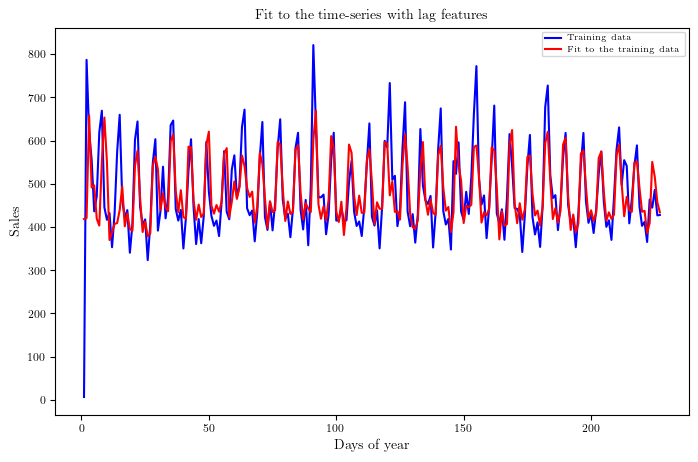

In [53]:
plot_ts_fit(average_sales, y_pred_lag, 'Days of year', 'Sales', \
            'Fit to the time-series with lag features', path_plots, 'forecasting_lag_features_fit.pdf', cm)

In [54]:
ts_cv_score(Xlag , y, 5, 1000, False, path_plots, cm)

Base Root Meat Squared Log Error is: 0.10842


The fit using lag features only fails to capture the peaks, but is in reasonable agreement and has a much better score than the original fit (0.14447) or the slightly better (0.14386, 0.14343) other fits

In [55]:
X4 = Xlag.join(X2, on='date').fillna(0.0)
X4.columns

Index(['dayofyear', 'lag_7', 'lag_2', 'lag_1', 'lag_4', 'lag_30', 'lag_5',
       'lag_14', 'lag_9', 'lag_28', 'lag_12', 'lag_6', 'const', 'trend',
       's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)',
       'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)',
       'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)', 'cos(4,freq=M)',
       'holiday'],
      dtype='object')

In [56]:
model4 = LinearRegression().fit(X4,y)
y_pred4 = pd.Series(
    model4.predict(X4),
    index = X4.index,
)

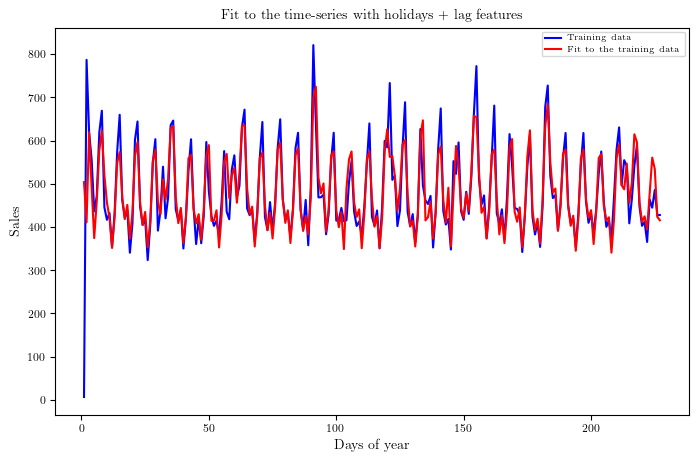

In [57]:
plot_ts_fit(average_sales, y_pred4, 'Days of year', 'Sales', \
            'Fit to the time-series with holidays + lag features', path_plots, 'forecasting_hol+lag_features_fit.pdf', cm)

In [58]:
ts_cv_score(X4 , y, 5, 1000, False, path_plots, cm)

Base Root Meat Squared Log Error is: 0.10437


Combining lag and holiday features allows us to keep improving the score, we now reach 0.10437. Combining with the multiple holiday features (X3) instead of a single holiday feature (X2) leads to a slightly better score (0.10413)

### Add Promotion feature

Restarting from Xlag, so that we have together the lag and promotion features

In [59]:
Xprom = Xlag_init.drop(columns=['sales', 'day', 'week', 'year', 'dayofmonth'])
Xprom

,onpromotion,dayofyear,lag_7,lag_2,lag_1,lag_4,lag_30,lag_5,lag_14,lag_9,lag_28,lag_12,lag_6
date,,,,,,,,,,,,,
2017-01-01,0.095398,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-02,6.628507,2.0,0.000000,0.000000,6.780304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-03,7.803591,3.0,0.000000,6.780304,786.928379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-04,12.860831,4.0,0.000000,786.928379,619.740224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-05,4.797980,5.0,0.000000,619.740224,555.608004,6.780304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,7.956790,223.0,464.520587,411.975126,365.536988,447.511203,420.202018,588.978207,468.630574,541.364768,429.567687,630.613063,541.915629
2017-08-12,4.664422,224.0,541.915629,365.536988,463.733851,402.786952,353.339710,447.511203,579.299027,408.568173,543.814324,497.113828,588.978207
2017-08-13,5.209315,225.0,588.978207,463.733851,444.798280,411.975126,429.567687,402.786952,630.613063,464.520587,617.734960,554.729385,447.511203


In [60]:
model_prom = LinearRegression().fit(Xprom,y)
y_pred_prom = pd.Series(
    model_prom.predict(Xprom),
    index = Xprom.index,
)

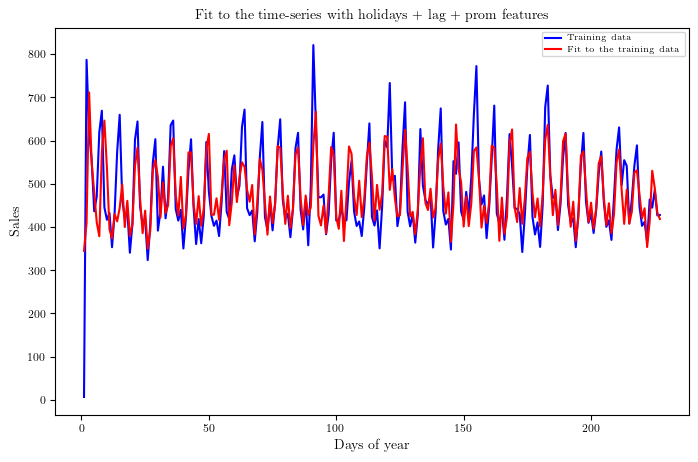

In [61]:
plot_ts_fit(average_sales, y_pred_prom, 'Days of year', 'Sales', \
            'Fit to the time-series with holidays + lag + prom features', path_plots, 'forecasting_hol+lag+prom_features_fit.pdf', cm)

In [62]:
ts_cv_score(Xprom , y, 5, 1000, False, path_plots, cm)

Base Root Meat Squared Log Error is: 0.10849


The score becomes worse after adding the promotion feature, so it should not be included. This is not a surprise, because dealing with promotions on average sales is totally undiscriminated, the information on store_nbr and categorical product is lost. 

## Dealing with feature selection

### Importance score

Decision trees, such as random forest, can be used to calculate a feature importance score, which estimates the relative usefulness of various features for data forecasting.

In [63]:
from sklearn.ensemble import RandomForestRegressor

# fit random forest model
model_rf = RandomForestRegressor(n_estimators=1000, random_state=1121218)
model_rf.fit(Xprom, y)


y_pred_rf = pd.Series(
    model_rf.predict(Xprom),
    index = Xprom.index,
)

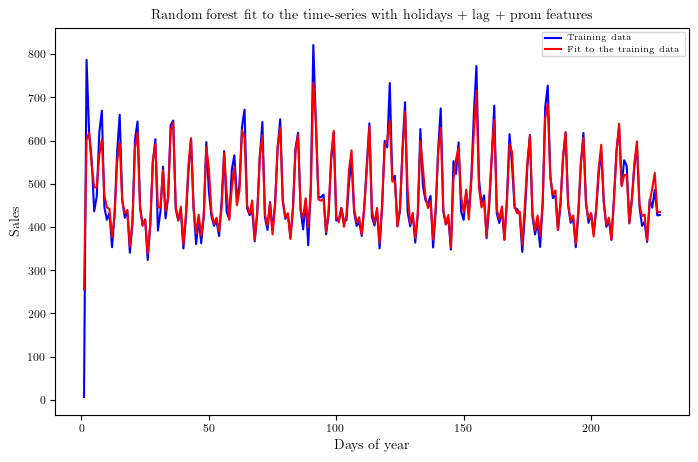

In [64]:
plot_ts_fit(average_sales, y_pred_rf, 'Days of year', 'Sales', \
            'Random forest fit to the time-series with holidays + lag + prom features', path_plots, 'forecasting_(rf)_hol+lag+prom_features_fit.pdf', cm)

In [65]:
ts_cv_score(Xprom , y, 5, 1000, False, path_plots, cm)

Base Root Meat Squared Log Error is: 0.10849


In [66]:
def plot_feature_importance(model_rf, threshold, path, filename, cm):
    
    # model_rf: model using a Random Forest Regressor
    from sklearn.ensemble import RandomForestRegressor

    names = names = Xprom.columns.values
    ticks = [i for i in range(len(names))]
    
    fig = plt.figure(figsize=(10*cm, 8*cm))
    ax = fig.add_subplot(111)
    
    cols = ['red' if x < threshold else 'green' for x in model_rf.feature_importances_]
    sns.barplot(x=model_rf.feature_importances_, y=ticks, palette=cols, orient='h')
    
    #ax.set_xlabel(r'Feature importance')
    ax.set_ylabel(r'Features')
    ax.set_yticks(ticks, names)
    ax.set_title('Feature importance')
    
    
    for p in ax.patches:
        _x = p.get_x() + p.get_width() + 0.01
        _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
        value = '{:.3f}'.format(p.get_width())
        ax.text(_x, _y, value, ha="left", va="center")
        
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')    

[0.05495535 0.05541443 0.27605689 0.07240032 0.07252442 0.02448123
 0.05073003 0.0221922  0.10756179 0.04485025 0.17017416 0.02925411
 0.01940482]


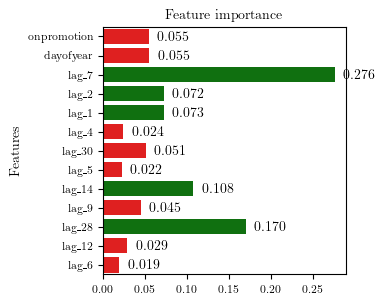

In [67]:
# print importance scores
print(model_rf.feature_importances_)
# plot importance scores
plot_feature_importance(model_rf, 0.06, path_plots, 'feature_importance.pdf', cm)  

### Using Recursive Feature Selection (RFE) to select the most relevant features

In [68]:
def feature_selection_nfeat(X, y, nfeat, path, filename, cm):
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.feature_selection import RFE
    
    # feature selection
    rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=nfeat)
    fit = rfe.fit(X, y)
    
    names = X.columns.values
    ticks = [i for i in range(len(names))]
    
    # print selected features
    
    #print('Selected Features:')
    #for i in range(len(fit.support_)):
    #    if fit.support_[i]:
    #        print(names[i])
    #    names = names = X.columns.values
    print('selected features:', names[rfe.get_support(indices=False)])
    
    # plot selected features
    fig = plt.figure(figsize=(10*cm, 8*cm))
    ax = fig.add_subplot(111)
    
    cols = ['green' if x < 2 else 'red' for x in fit.ranking_]
    sns.barplot(x=fit.ranking_, palette=cols, y=ticks, orient='h')
    
    ax.set_xlabel(r'Feature ranking')
    ax.set_ylabel(r'Features')
    ax.set_yticks(ticks, names)
    ax.set_title('Feature selection')

    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')    

selected features: ['lag_7' 'lag_2' 'lag_1' 'lag_14' 'lag_28']


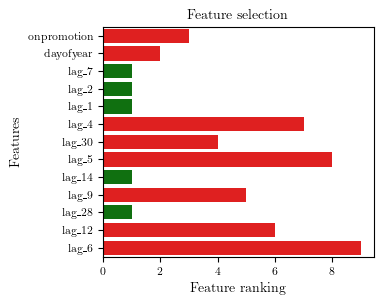

In [69]:
feature_selection_nfeat(Xprom, y, 5, path_plots, 'rfe_feature_selection.pdf', cm)  

In [70]:
def plot_outcome_rfecv(rfecv, path, filename, cm):
    
    
    n_scores = len(rfecv.cv_results_["mean_test_score"])

    # plot selected features and scores
    fig = plt.figure(figsize=(10*cm, 8*cm))
    ax = fig.add_subplot(111)    
   
    ax.errorbar(
        range(1, n_scores + 1),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
        c='navy',
    )
    ax.set(title=r"Recursive Feature Elimination with correlated features",
           xlabel=r"Number of features selected",
           ylabel=r"Mean test score",
          )

    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')    

In [71]:
def feature_selection_withcv(X, y, path, cm):

    # Recursive feature elimination with cross-validation to select features

    from sklearn.feature_selection import RFECV
    from sklearn.model_selection import KFold
    from sklearn.linear_model import RidgeCV
    from xgboost.sklearn import XGBRegressor

    from sklearn.utils.multiclass import type_of_target
    print(f"Type of target: {type_of_target(y)}")
    
    min_features_to_select = 1  # Minimum number of features to consider
    
    xgb = XGBRegressor()
    ridge = RidgeCV() # estimator with a fit method that provides information about feature importance 
    
    cv = KFold(5)    # cross-validation splitting strategy.
                     # Splits into K folds, trains on K-1 and then tests on the left-out.

    rfecv = RFECV(
        estimator=xgb,
        step=1,
        cv=cv,
        scoring="r2",
        min_features_to_select=min_features_to_select,
        n_jobs=4,
    )
    
    rfecv.fit(X, y)
    optimal_n_feat = rfecv.n_features_
    
    print(f"Optimal number of features: {optimal_n_feat }")
    
    plot_outcome_rfecv(rfecv, path_plots, 'rfecv_feature_selection.pdf', cm)
    
    return rfecv, optimal_n_feat

Type of target: continuous
Optimal number of features: 11


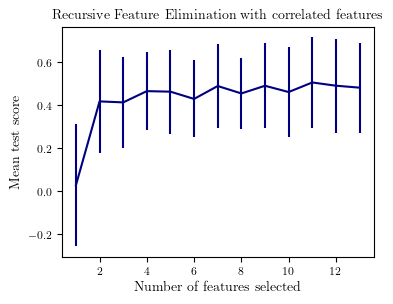

In [72]:
rfecv, optimal_n_feat = feature_selection_withcv(Xprom, y, path_plots, cm)

The optimal number of features ends up being 11, but little improvement is to be expected as soon as 2 featues are included.

## GRADIENT BOOSTING METHODS

## Data preparation

As mentioned before, we split train and test data for our own purposes 

In [73]:
gb_train_data = X4.loc[X4.dayofyear<152]
#gb_train_data

In [74]:
y_train = y_pred[0:151]
#y_train

In [75]:
gb_test_data = X4.loc[X4.dayofyear>=152]
#gb_test_data

In [76]:
y_test = y_pred[151:]
#y_test

In [77]:
print(type(gb_train_data))

<class 'pandas.core.frame.DataFrame'>


In [78]:
gb_train_data.columns

Index(['dayofyear', 'lag_7', 'lag_2', 'lag_1', 'lag_4', 'lag_30', 'lag_5',
       'lag_14', 'lag_9', 'lag_28', 'lag_12', 'lag_6', 'const', 'trend',
       's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)',
       'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)',
       'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)', 'cos(4,freq=M)',
       'holiday'],
      dtype='object')

In [79]:
#[LightGBM] [Fatal] Do not support special JSON characters in feature name
import re
#gb_train_data = gb_train_data.rename(columns = lambda x:re.sub('lag_', 'lag', x))

gb_train_data = gb_train_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9()]+', '', x))
gb_test_data = gb_test_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9()]+', '', x))
# removing , and _


print(gb_train_data.columns)

Index(['dayofyear', 'lag7', 'lag2', 'lag1', 'lag4', 'lag30', 'lag5', 'lag14',
       'lag9', 'lag28', 'lag12', 'lag6', 'const', 'trend', 's(27)', 's(37)',
       's(47)', 's(57)', 's(67)', 's(77)', 'sin(1freqM)', 'cos(1freqM)',
       'sin(2freqM)', 'cos(2freqM)', 'sin(3freqM)', 'cos(3freqM)',
       'sin(4freqM)', 'cos(4freqM)', 'holiday'],
      dtype='object')


In [124]:
def plot_evaluation_gb_methods(x_axis, test_data, pred_data, x_label, y_label, path, filename):


    fig = plt.figure(figsize=(18,9))
    ax1 = fig.add_subplot(121)
    ax1a = ax1.plot(x_axis, test_data, c='navy', label = 'test')
    ax1b = ax1.plot(x_axis, pred_data, c='red', label = 'predicted')
    ax1.set(xlabel=x_label, ylabel=y_label)
    ax1.legend(loc='upper right')

    ax2 = fig.add_subplot(122)
    ax2a = ax2.scatter(test_data,pred_data, c='navy')
    
    lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
    ]
    ax2b = ax2.plot(lims, lims, c='blue', alpha=0.75, zorder=-1)
    
    #ax2b = ax2.axline((0, 0), slope=1)
    ax2.set(xlabel='Test', ylabel='Predicted')
    
    fig.tight_layout()
    file = path / str(filename)
    fig.savefig(file, format='pdf')    

### XGBOOST

In [80]:
from xgboost import XGBRegressor

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [81]:
# Initialize time series split
xgb_cv = TimeSeriesSplit(n_splits=4)

# define model
xgb_model =  XGBRegressor()

# define parameters as dict
xgb_parameters = {
    "max_depth": [3,4,6,5,10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7],
}

In [82]:
xgb_grid_search = GridSearchCV(estimator = xgb_model, cv = xgb_cv, param_grid = xgb_parameters)
xgb_grid_search.fit(gb_train_data,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, imp...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel

In [83]:
# Evaluate grid_search results
xgb_pred = xgb_grid_search.predict(gb_test_data)

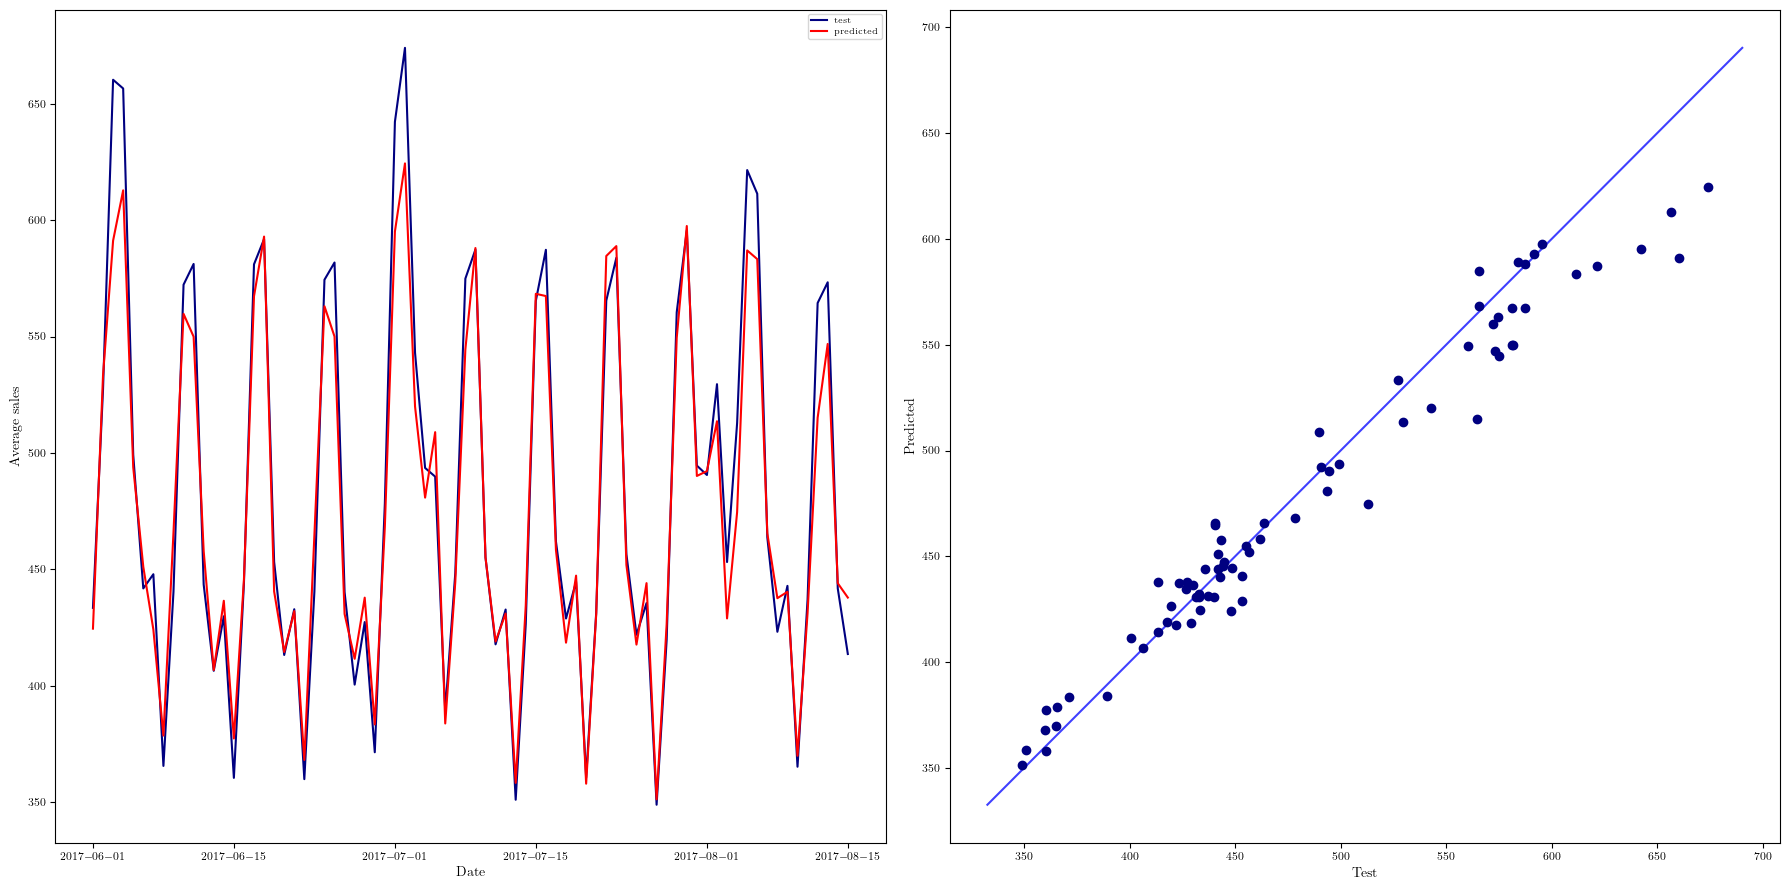

In [126]:
plot_evaluation_gb_methods(y_test.index, y_test, xgb_pred, 'Date', 'Average sales', path_plots, 'plot_evaluation_XGB.pdf')

## LightGB

In [88]:
import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [99]:
# Initialize time series split
lgb_cv = TimeSeriesSplit(n_splits=4)

# define model
lgb_model =  lgb.LGBMRegressor()

# define parameters as dict
lgb_parameters = {
    "max_depth": [3,4,5,5],
    "num_leaves": [2,3,4,5,10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [10, 30, 50, 75, 100], #num_iterations
    "feature_fraction": [0.3, 0.5, 0.7],
    "min_data_in_bin": [1],
    "min_data_in_leaf": [1],
    "verbose": [-1],
}

# "num_leaves": [10,20,30,40,100,120]

In [100]:
lgb_grid_search = GridSearchCV(estimator = lgb_model, cv = lgb_cv, param_grid = lgb_parameters)
lgb_grid_search.fit(gb_train_data,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'feature_fraction': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5, 5], 'min_data_in_bin': [1],
                         'min_data_in_leaf': [1],
                         'n_estimators': [10, 30, 50, 75, 100],
                         'num_leaves': [2, 3, 4, 5, 10], 'verbose': [-1]})

In [101]:
# Evaluate grid_search results
lgb_pred = lgb_grid_search.predict(gb_test_data)

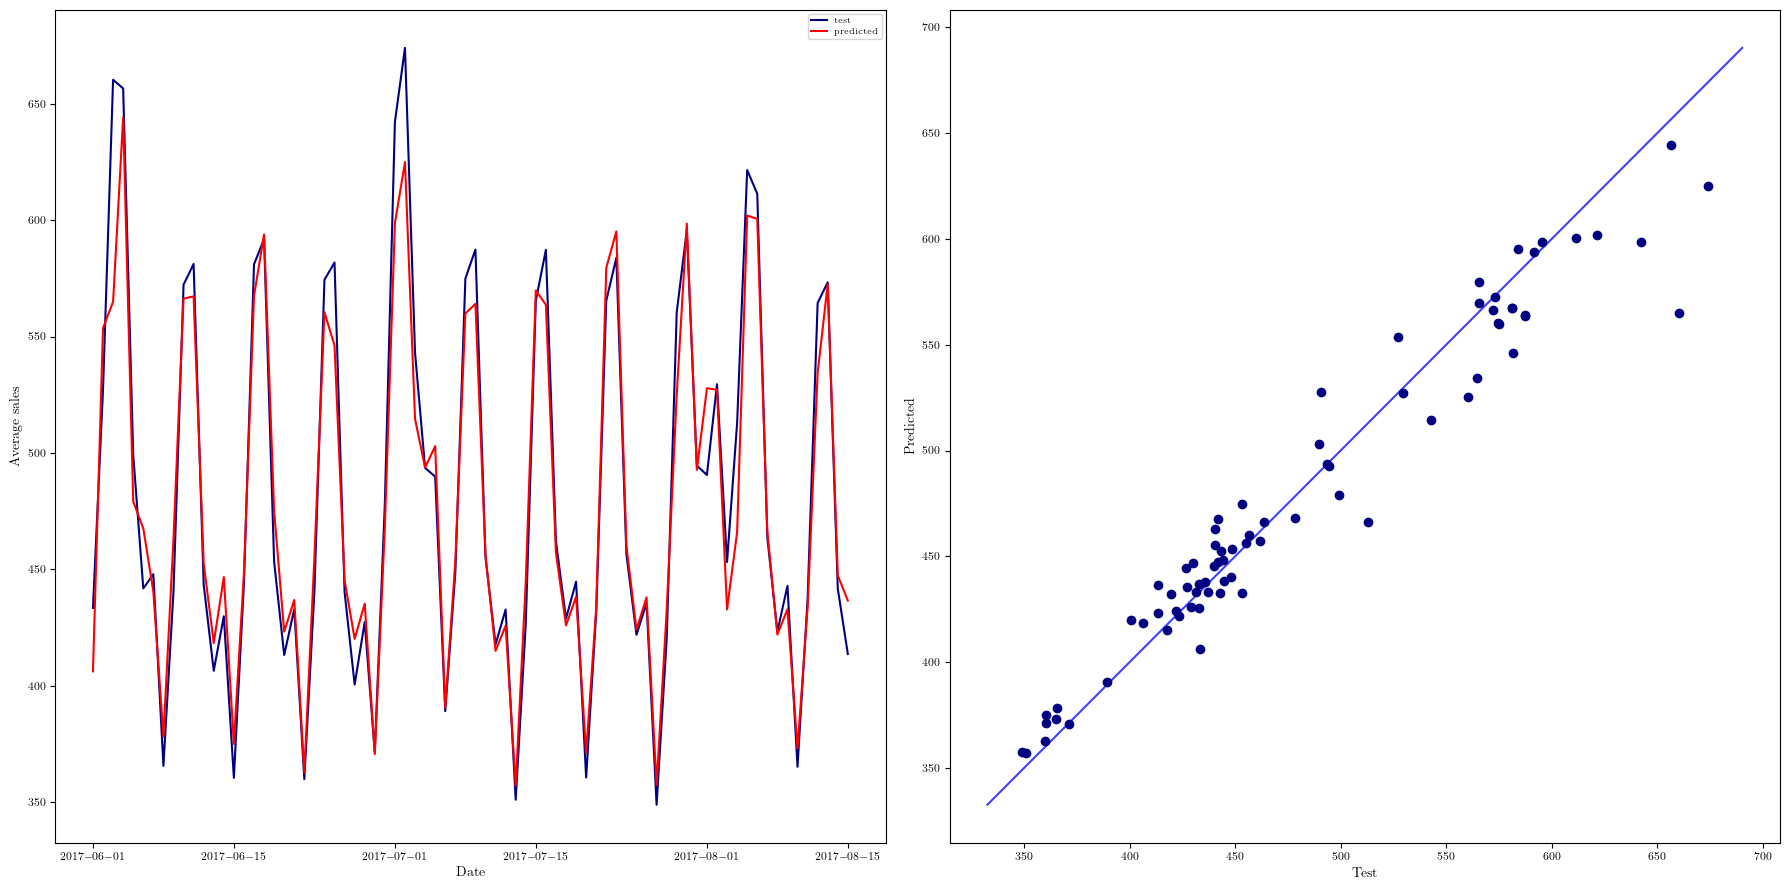

In [127]:
plot_evaluation_gb_methods(y_test.index, y_test, lgb_pred, 'Date', 'Average sales', path_plots, 'plot_evaluation_LGB.pdf')

In [ ]:
TBD evaluation metrics

In [ ]:
TBD DROP DATE COLUMN